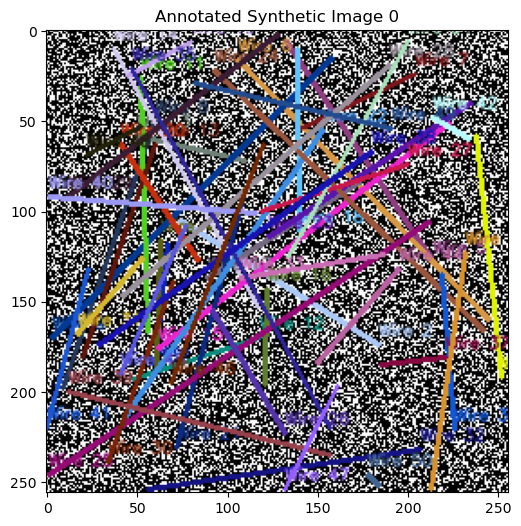

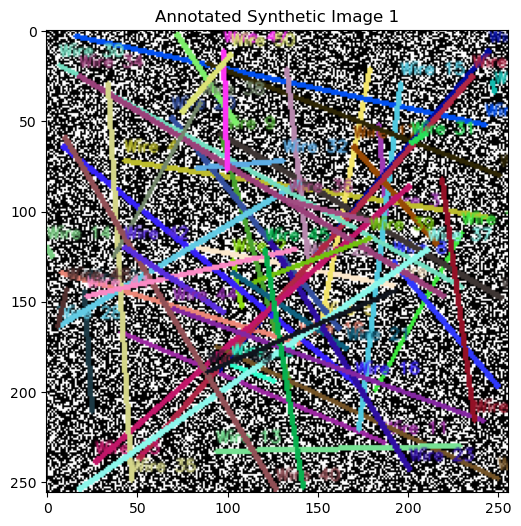

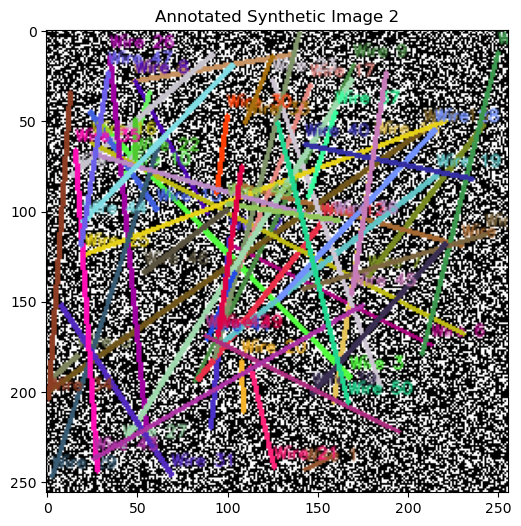

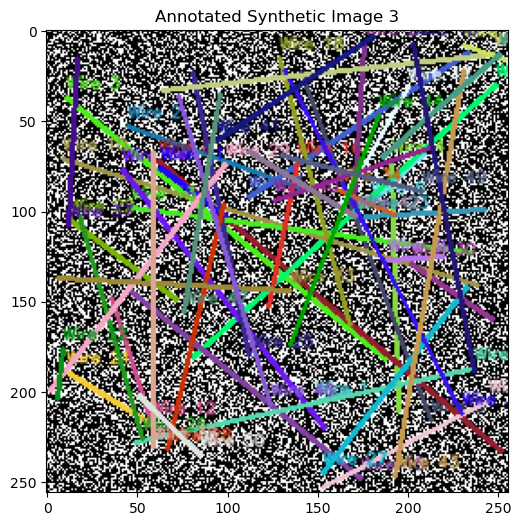

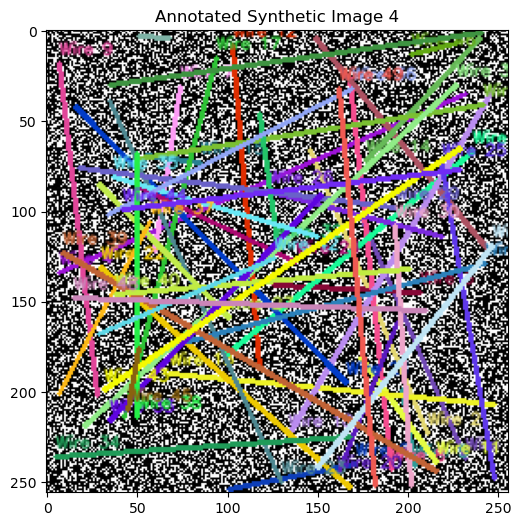

Saved 1000 synthetic SEM images in synthetic_sem_images
Saved 1000 annotated SEM images in synthetic_sem_images_annotated


In [43]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

# Directories to save synthetic SEM images and length of nanowires
synthetic_output_dir = "synthetic_sem_images"
annotated_output_dir = "synthetic_sem_images_annotated"
lengths_file = "nanowire_lengths.csv"

# Create directories if they don't exist
os.makedirs(synthetic_output_dir, exist_ok=True)
os.makedirs(annotated_output_dir, exist_ok=True)

# Check if the file exists, otherwise create it with a header
if not os.path.exists(lengths_file):
    with open(lengths_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Lengths"])  # Header row
        
# Function to generate random colors
def generate_random_color():
    """
    Generate a random color in BGR format.
    """
    return tuple(np.random.randint(0, 256, 3).tolist())

# Function to generate and save synthetic SEM images
def generate_synthetic_sem_image(image_size=(256, 256), num_nanowires=50):
    """
    Generate a synthetic SEM-like image with random nanowire patterns.
    """
    image = np.zeros(image_size, dtype=np.uint8)

    labels = []  # Store the start and end points for labeling
    actual_lengths = []  # Store the actual lengths of nanowires

    for wire_idx in range(num_nanowires):
        # Random start and end points for "nanowires"
        x1, y1 = np.random.randint(0, image_size[1]), np.random.randint(0, image_size[0])
        x2, y2 = np.random.randint(0, image_size[1]), np.random.randint(0, image_size[0])

        
        # Draw a white line (simulating a nanowire)
        thickness = np.random.randint(1, 3)  # Random thickness
        cv2.line(image, (x1, y1), (x2, y2), color=255, thickness=thickness)

        # Store the start and end points with a random color
        labels.append(((x1, y1), (x2, y2), f"Wire {wire_idx + 1}", generate_random_color()))

    # Add random Gaussian noise
    noise = np.random.normal(0, 3, image_size).astype(np.uint8)
    noisy_image = cv2.add(image, noise)

    return noisy_image, labels

# Function to annotate an image with colored labels and underlines
def annotate_image(image, labels):
    """
    Annotate the image with labels and underline nanowires in unique colors.
    """
    annotated_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored text and lines
    for start, end, label, color in labels:
        x, y = start
        x2, y2 = end
        
        # Draw the underline (nanowire color)
        cv2.line(annotated_image, (x, y), (x2, y2), color=color, thickness=2)
        
        # Add the label near the starting point
        cv2.putText(
            annotated_image, label, (x, y - 5), 
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=0.3, color=color, thickness=1, lineType=cv2.LINE_AA
        )
    return annotated_image

# Generate and save synthetic SEM images
num_synthetic_images = 1000
for i in range(num_synthetic_images):
    # Generate image and labels
    synthetic_image, labels = generate_synthetic_sem_image(image_size=(256, 256), num_nanowires=50)
    
    # Save unannotated image
    unannotated_path = os.path.join(synthetic_output_dir, f"synthetic_{i:03d}.png")
    cv2.imwrite(unannotated_path, synthetic_image)
    
    # Annotate image and save
    annotated_image = annotate_image(synthetic_image, labels)
    annotated_path = os.path.join(annotated_output_dir, f"synthetic_annotated_{i:03d}.png")
    cv2.imwrite(annotated_path, annotated_image)

    # Save actual lengths in the file
    actual_lengths = [np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) for (x1, y1), (x2, y2), _, _ in labels]
    with open(lengths_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([unannotated_path] + actual_lengths)

    # Display a few synthetic images
    if i < 5:  # Display only the first 5 images for preview
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
        plt.title(f"Annotated Synthetic Image {i}")
        plt.show()

print(f"Saved {num_synthetic_images} synthetic SEM images in {synthetic_output_dir}")
print(f"Saved {num_synthetic_images} annotated SEM images in {annotated_output_dir}")


Found 1000 files in the directory.
Processing image: synthetic_000.png
Processing image: synthetic_001.png
Processing image: synthetic_002.png
Processing image: synthetic_003.png
Processing image: synthetic_004.png
Processing image: synthetic_005.png
Processing image: synthetic_006.png
Processing image: synthetic_007.png
Processing image: synthetic_008.png
Processing image: synthetic_009.png
Processing image: synthetic_010.png
Processing image: synthetic_011.png
Processing image: synthetic_012.png
Processing image: synthetic_013.png
Processing image: synthetic_014.png
Processing image: synthetic_015.png
Processing image: synthetic_016.png
Processing image: synthetic_017.png
Processing image: synthetic_018.png
Processing image: synthetic_019.png
Processing image: synthetic_020.png
Processing image: synthetic_021.png
Processing image: synthetic_022.png
Processing image: synthetic_023.png
Processing image: synthetic_024.png
Processing image: synthetic_025.png
Processing image: synthetic_0

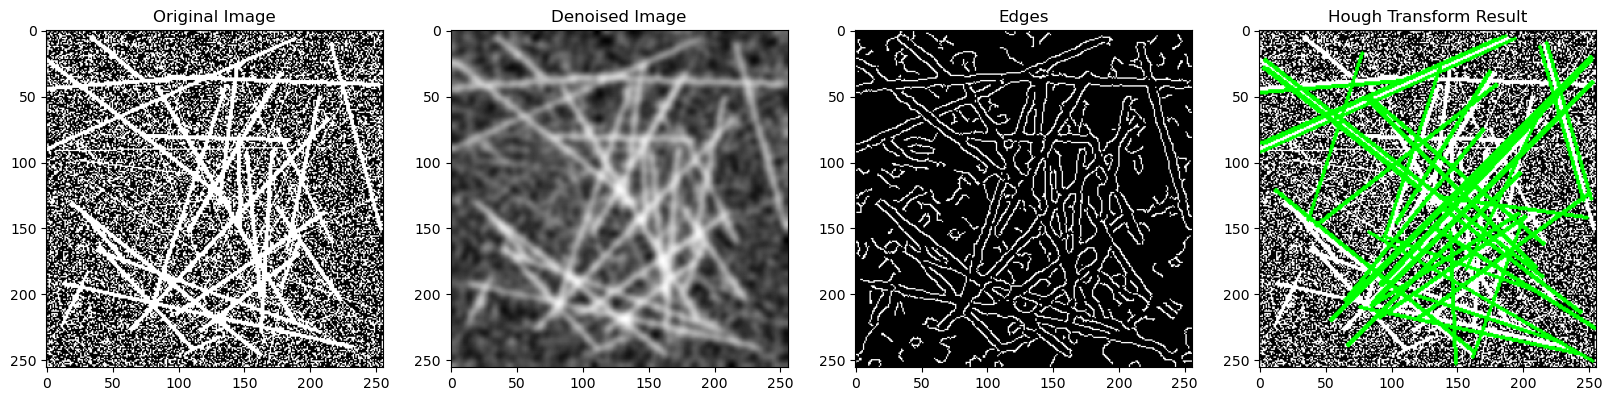

Processed 1 images and displayed 3 of them.


In [45]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
import csv

# Configure logging for error tracking
logging.basicConfig(level=logging.ERROR)

# Directory where synthetic SEM images are saved
synthetic_output_dir = "synthetic_sem_images"

# Initialize list to hold processed images
processed_images = []
measured_lengths = []  # To store Hough Transform measured lengths

# Load actual nanowire lengths from the file
actual_lengths_dict = {}  # Store filename -> actual lengths
with open("nanowire_lengths.csv", mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        filename = row[0]
        actual_lengths_dict[filename] = list(map(float, row[1:]))
        
# Check if the directory exists
if not os.path.exists(synthetic_output_dir):
    print(f"Directory '{synthetic_output_dir}' does not exist. Please check the path.")
    exit()

# Get a list of all synthetic images
synthetic_image_files = sorted(os.listdir(synthetic_output_dir))
print(f"Found {len(synthetic_image_files)} files in the directory.")

# Process all images
for image_file in synthetic_image_files:
    # Construct the full path to the image
    image_path = os.path.join(synthetic_output_dir, image_file)
    
    # Load the synthetic image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded successfully
    if image is None:
        logging.error(f"Failed to load image: {image_path}")
        continue  # Skip to the next file if the image is not loaded

    print(f"Processing image: {image_file}")
    
    # Step 1: Noise reduction
    # Option 1: Gaussian Blur
    denoised_image = cv2.GaussianBlur(image, (15, 15), 0)
    
    # Option 2: Median Filtering (Uncomment the next line to use this)
    # denoised_image = cv2.medianBlur(image, 15)
    
    # Option 3: Bilateral Filtering (Uncomment the next line to use this)
    # denoised_image = cv2.bilateralFilter(image, 9, 75, 75)
    
    # Step 2: Edge detection using Canny
    edges = cv2.Canny(denoised_image, threshold1=50, threshold2=100, apertureSize=3)
    
# Step 3: Hough Line Transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=20, minLineLength=100, maxLineGap=15)

# Check if `edges` and `image` are valid
if edges is None or image is None:
    print("Error: Edges or Image not defined.")
    exit()

# Create a copy of the original image for visualization
line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Measure and visualize the lengths of the detected lines
measured_lengths_for_image = []  # Store the measured lengths for this image

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate the length of the line
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        measured_lengths_for_image.append(length)
        # Draw the detected line on the image
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
else:
    print("No lines were detected.")

# Save measured lengths
measured_lengths.append(measured_lengths_for_image)

# Retrieve actual lengths for comparison
if image_path in actual_lengths_dict:
    actual_lengths.append([actual_lengths_dict[image_path]])
    
# Compute and display statistics

# Flatten and clean up the measured_lengths and actual_lengths
measured_flat = [float(length) for sublist in measured_lengths for length in sublist]

# Flatten actual_lengths more carefully
def flatten(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse
            flat_list.extend(flatten(item))
        else:  # If it's a scalar, append it directly
            flat_list.append(item)
    return flat_list

# Flatten actual_lengths
actual_flat = flatten(actual_lengths)

# Convert all elements to floats
actual_flat = [float(item) for item in actual_flat]

# Print shapes and samples for debugging
print("Sample of measured_flat:", measured_flat[:5])
print("Sample of actual_flat:", actual_flat[:5])

# Ensure both lists have the same length
min_length = min(len(measured_flat), len(actual_flat))
measured_flat = measured_flat[:min_length]
actual_flat = actual_flat[:min_length]

# Compute and display statistics
if measured_flat and actual_flat:
    mse = np.mean((np.array(measured_flat) - np.array(actual_flat))**2)
    mae = np.mean(np.abs(np.array(measured_flat) - np.array(actual_flat)))
    avg_measured = np.mean(measured_flat)
    avg_actual = np.mean(actual_flat)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Average Measured Length: {avg_measured:.2f}")
    print(f"Average Actual Length: {avg_actual:.2f}")
else:
    print("No valid lengths were found for comparison.")
# Append the processed image
processed_images.append((image, denoised_image, edges, line_image))

# Check if any images were processed
if not processed_images:
    print("No valid images were processed.")
    exit()

# Display results for only 3 images
for idx, (original, denoised, edges, line_image) in enumerate(processed_images[:3]):
    plt.figure(figsize=(20, 5))
    
    # Original Image
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    
    # Denoised Image
    plt.subplot(1, 4, 2)
    plt.title("Denoised Image")
    plt.imshow(denoised, cmap='gray')
    
    # Edges
    plt.subplot(1, 4, 3)
    plt.title("Edges")
    plt.imshow(edges, cmap='gray')
    
    # Hough Transform Result
    plt.subplot(1, 4, 4)
    plt.title("Hough Transform Result")
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    
    plt.show()

print(f"Processed {len(processed_images)} images and displayed 3 of them.")


In [ ]:
#NEED TO COMPLETE THE CODE